# Notebook for calculating and presenting training results

## Results for model traind over a rotor-speech dataset 

In [1]:
# imports
# scientific libreries
import numpy as np
import librosa
import soundfile as sf
import torch
from sklearn.cluster import KMeans

# utilities
import os
import joblib
from einops import rearrange

# for show
import IPython
sr = 32000

from librosa.display import waveplot, specshow
from matplotlib import pyplot as plt

In [2]:
# utility functions

def plot_mask(mask, *, ax=None):
    if ax is None:
        ax = plt.gca()
    image = ax.imshow(
        mask,
        interpolation='nearest',
        vmin=0,
        vmax=1,
        origin='lower'
    )
    cbar = plt.colorbar(image, ax=ax)
    return ax


def plot_stft(stft_signal, *, ax=None):
    if ax is None:
        ax = plt.gca()

    stft_signal = np.abs(stft_signal)

    stft_signal = 10 * np.log10(
        np.maximum(stft_signal, np.max(stft_signal) / 1e6))
    # 1e6: 60 dB is sufficient

    image = ax.imshow(
        stft_signal,
        interpolation='nearest',
        origin='lower',
    )
    cbar = plt.colorbar(image, ax=ax)
    cbar.set_label('Energy / dB')
    return ax

stft_params = {
    'n_fft': 512,
    'win_length': 512,
    'hop_length': 128,
}

def stft(signal):
    return librosa.stft(signal, **stft_params)

def istft(tfs):
    return librosa.istft(tfs,
                         win_length=stft_params['win_length'],
                         hop_length=stft_params['hop_length'])

def apply_mask(mask, tfs, i):
    return (mask == i)*tfs

In [3]:
# model_path = "C:\\Users\\orsht\\Documents\\236605\\Project\\Shai\\outputs\\models_ground_truth\\whitenoise_speech-832-128-128\\SDR_8_SIR_23_SAR_8_11-11-33.pt"
data_path = "C:\\Users\\orsht\\Documents\\236605\\Project\\Shai\\outputs\\datasets_dir\\whitenoise_speech-832-128-128\\test\\0"

## Loading data

loading data of a test example

In [4]:
props = [
    'imag_tfs',
    'real_tfs',
    'ground_truth_mask',
    'soft_labeled_mask',
    'wavs',
]

data_dict = {}
for prop in props:
    data_dict[prop] = joblib.load(os.path.join(data_path, prop))

data_dict['stft'] = data_dict['imag_tfs']*1j + data_dict['real_tfs']
# data_dict

In [5]:
# The audio for seperation

original_audio = librosa.istft(data_dict['stft'], hop_length=128, win_length=512)

IPython.display.Audio(original_audio, rate=sr)

visualization of the ground truth mask and the stft used

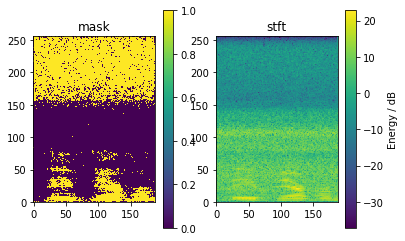

In [6]:
fig, axes = plt.subplots(1,2)
axes[0].title.set_text('mask')
plot_mask(data_dict['ground_truth_mask'], ax=axes[0])
axes[1].title.set_text('stft')
plot_stft(data_dict['stft'], ax=axes[1])

# Loading models data

Loading two models trained over the same dataset, one traing using groung truth labels and one using soft label mask

In [7]:
from spatial_two_mics.dnn.utils.model_logger import load_and_create_the_model
gt_model_demo = "C:\\Users\\orsht\\Documents\\236605\\Project\\Shai\\outputs\\models_ground_truth\\whitenoise_speech-832-128-128"
sl_model_demo = "C:\\Users\\orsht\\Documents\\236605\\Project\\Shai\\outputs\\models\\whitenoise_speech-832-128-128"

gt_model_path = os.path.join(gt_model_demo, 'SDR_8_SIR_23_SAR_8_11-11-33.pt')
sl_model_path = os.path.join(sl_model_demo, 'SDR_6_SIR_20_SAR_6_12-01-11.pt')

In [8]:
# loading a pretrained model
gt_model, _, _, _, gt_args, gt_mean_tr, gt_std_tr, _ = load_and_create_the_model(gt_model_path)
# this is nessesary for avoiding gradient calculations
gt_model.eval() 

DataParallel(
  (module): BLSTMEncoder(
    (rnn): LSTM(257, 1024, num_layers=2, batch_first=True)
    (affine): Linear(in_features=1024, out_features=10280, bias=True)
  )
)

In [9]:
# loading a pretrained model
sl_model, _, _, _, sl_args, sl_mean_tr, sl_std_tr, _ = load_and_create_the_model(sl_model_path)
# this is nessesary for avoiding gradient calculations
sl_model.eval() 

DataParallel(
  (module): BLSTMEncoder(
    (rnn): LSTM(257, 1024, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (affine): Linear(in_features=2048, out_features=10280, bias=True)
  )
)

In [10]:
# some arguments about the model architecture settings
gt_bidirectional = gt_args.bidirectional
gt_D = gt_args.embedding_depth
gt_n_layers = gt_args.n_layers
gt_training_labels = gt_args.training_labels
gt_bidirectional, gt_D, gt_n_layers, gt_training_labels

(False, 40, 2, 'ground_truth')

In [11]:
# some arguments about the model architecture settings
sl_bidirectional = sl_args.bidirectional
sl_D = sl_args.embedding_depth
sl_n_layers = sl_args.n_layers
sl_training_labels = sl_args.training_labels
sl_bidirectional, sl_D, sl_n_layers, sl_training_labels

(True, 40, 2, 'duet')

seperating the sound input using the masks (ground truth and sofr label)

In [19]:
# applaing the ground truth mask
src1_ground_truth = apply_mask(data_dict['ground_truth_mask'], data_dict['stft'], 1)
src2_ground_truth = apply_mask(data_dict['ground_truth_mask'], data_dict['stft'], 0)

In [20]:
src1_soft_labeled = apply_mask(data_dict['soft_labeled_mask'], data_dict['stft'], 0)
src2_soft_labeled = apply_mask(data_dict['soft_labeled_mask'], data_dict['stft'], 1)

creating the channels mask using the model trained over ground truth masks

In [21]:
# feed the stft to the model:
mixture_tfs = data_dict['stft']
# pyTorch does not support complex Tensors, so use the complex norm:
input_tfs = np.abs(mixture_tfs)
X = torch.Tensor(input_tfs)
# add batch dimention first, and move frequancy dimention last:
X = rearrange(X, '(b f) t -> b t f', b=1)
# normalize by mean and varient of training set
X -= gt_mean_tr
X /= gt_std_tr
gt_Y = gt_model(X)
# appleing the KMeans clustering algorithem
kmeans = KMeans(n_clusters=2)
gt_Y_temp = gt_Y[0].detach().numpy()
gt_Y_temp = (gt_Y_temp - np.mean(gt_Y_temp, axis=0)) / (np.std(gt_Y_temp, axis=0) + 10e-8)
gt_pred_mask = kmeans.fit_predict(gt_Y_temp)
gt_pred_mask = gt_pred_mask.reshape(X[0].size())
gt_pred_mask.shape



(188, 257)

creating the channels mask using the model trained over soft label masks

In [22]:
# feed the stft to the model:
mixture_tfs = data_dict['stft']
# pyTorch does not support complex Tensors, so use the complex norm:
input_tfs = np.abs(mixture_tfs)
X = torch.Tensor(input_tfs)
# add batch dimention first, and move frequancy dimention last:
X = rearrange(X, '(b f) t -> b t f', b=1)
# normalize by mean and varient of training set
X -= sl_mean_tr
X /= sl_std_tr
sl_Y = sl_model(X)
# appleing the KMeans clustering algorithem
kmeans = KMeans(n_clusters=2)
sl_Y_temp = sl_Y[0].detach().numpy()
sl_Y_temp = (sl_Y_temp - np.mean(sl_Y_temp, axis=0)) / (np.std(sl_Y_temp, axis=0) + 10e-8)
sl_pred_mask = kmeans.fit_predict(sl_Y_temp)
sl_pred_mask = sl_pred_mask.reshape(X[0].size())
sl_pred_mask.shape



(188, 257)

seperating the sound input using the masks created by the models

In [23]:
src1_gt_model = apply_mask(gt_pred_mask.T, mixture_tfs, 1)
src2_gt_model = apply_mask(gt_pred_mask.T, mixture_tfs, 0)

In [24]:
src1_sl_model = apply_mask(sl_pred_mask.T, mixture_tfs, 0)
src2_sl_model = apply_mask(sl_pred_mask.T, mixture_tfs, 1)

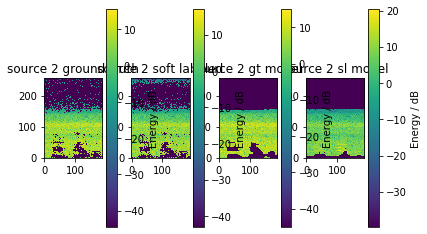

In [25]:
fig, axes = plt.subplots(1,4)
axes[0].title.set_text('source 2 ground truth')
plot_stft(src2_ground_truth, ax=axes[0])
axes[1].title.set_text('source 2 soft labeled')
plot_stft(src2_soft_labeled, ax=axes[1])
axes[2].title.set_text('source 2 gt model')
plot_stft(src2_gt_model, ax=axes[2])
axes[3].title.set_text('source 2 sl model')
plot_stft(src2_sl_model, ax=axes[3])

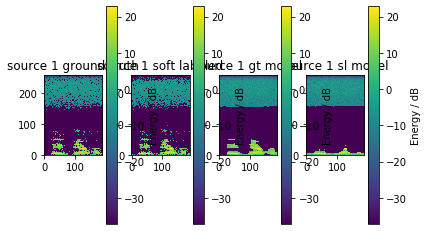

In [26]:
fig, axes = plt.subplots(1,4)
axes[0].title.set_text('source 1 ground truth')
plot_stft(src1_ground_truth, ax=axes[0])
axes[1].title.set_text('source 1 soft labeled')
plot_stft(src1_soft_labeled, ax=axes[1])
axes[2].title.set_text('source 1 gt model')
plot_stft(src1_gt_model, ax=axes[2])
axes[3].title.set_text('source 1 sl model')
plot_stft(src1_sl_model, ax=axes[3])

In [31]:
IPython.display.Audio(istft(src1_ground_truth), rate=sr)

In [32]:
IPython.display.Audio(istft(src1_soft_labeled), rate=sr)

In [33]:
IPython.display.Audio(istft(src1_gt_model), rate=sr)

In [34]:
IPython.display.Audio(istft(src1_sl_model), rate=sr)

# Evaluating the model

Our trainning is performed using a loss function, calculating the divergence between the model created mask and the original (ground truth or soft label, depands on the model).
To asses the model's quality, we clculate a parameter called SDR-Sound Distortion Ratio.
Here is a finction calculating if for a given sample.

In [35]:
def bss_eval(generated, src_num ,sources):
    # Current target
    src_num -= 1
    min_len = min([len(generated), len(sources[src_num])])
    sources = sources[:, :min_len]
    generated = generated[:min_len]
    target = sources[src_num]
    
    # Target contribution
    s_target = target * np.dot(target, generated.T) / np.dot(target, target.T)

    # Interference contribution
    pse = np.dot(np.dot(sources, generated.T), np.linalg.inv(np.dot(sources, sources.T))).T.dot( sources)
    e_interf = pse - s_target

    # Artifact contribution
    e_artif = generated - pse

    # Interference + artifacts contribution
    e_total = e_interf + e_artif

    # Computation of the log energy ratios
    sdr = 10*np.log10(sum(s_target**2) / sum(e_total**2));
    sir = 10*np.log10(sum(s_target**2) / sum(e_interf**2));
    sar = 10*np.log10(sum((s_target + e_interf)**2) / sum(e_artif**2));

    return sdr, sir, sar

Models' SDR, SIR and SAR

In [39]:
src1_gt_reconstructed = istft(src1_gt_model)
src2_gt_reconstructed = istft(src2_gt_model)
src1_sl_reconstructed = istft(src1_sl_model)
src2_sl_reconstructed = istft(src2_sl_model)

src1_gt_model_sdr, src1_gt_model_sir, src1_gt_model_sar = bss_eval(src1_gt_reconstructed, 2, np.asarray(data_dict['wavs']))
src2_gt_model_sdr, src2_gt_model_sir, src2_gt_model_sar = bss_eval(src2_gt_reconstructed, 1, np.asarray(data_dict['wavs']))
src1_sl_model_sdr, src1_sl_model_sir, src1_sl_model_sar = bss_eval(src1_sl_reconstructed, 2, np.asarray(data_dict['wavs']))
src2_sl_model_sdr, src2_sl_model_sir, src2_sl_model_sar = bss_eval(src2_sl_reconstructed, 1, np.asarray(data_dict['wavs']))

total_gt_model_sdr = (src1_gt_model_sdr + src2_gt_model_sdr) / 2
total_gt_model_sir = (src1_gt_model_sir + src2_gt_model_sir) / 2
total_gt_model_sar = (src1_gt_model_sar + src2_gt_model_sar) / 2
total_sl_model_sdr = (src1_sl_model_sdr + src2_sl_model_sdr) / 2
total_sl_model_sir = (src1_sl_model_sir + src2_sl_model_sir) / 2
total_sl_model_sar = (src1_sl_model_sar + src2_sl_model_sar) / 2

total_gt_model_sdr, total_gt_model_sir, total_gt_model_sar, total_sl_model_sdr, total_sl_model_sir, total_sl_model_sar

(8.546271164374778,
 23.84310247065456,
 8.844289969478435,
 3.1606898769405163,
 17.13583598500899,
 4.008803693806947)

Treditional masks' SDR, SIR and SAR

In [41]:


src1_ground_truth_rec = istft(src1_ground_truth)
src2_ground_truth_rec = istft(src2_ground_truth)
src1_soft_labeled_rec = istft(src1_soft_labeled)
src2_soft_labeled_rec = istft(src2_soft_labeled)

src1_gt_sdr, src1_gt_sir, src1_gt_sar = bss_eval(src1_ground_truth_rec, 2, np.asarray(data_dict['wavs']))
src2_gt_sdr, src2_gt_sir, src2_gt_sar = bss_eval(src2_ground_truth_rec, 1, np.asarray(data_dict['wavs']))
src1_sl_sdr, src1_sl_sir, src1_sl_sar = bss_eval(src1_soft_labeled_rec, 2, np.asarray(data_dict['wavs']))
src2_sl_sdr, src2_sl_sir, src2_sl_sar = bss_eval(src2_soft_labeled_rec, 1, np.asarray(data_dict['wavs']))

total_gt_sdr = (src1_gt_sdr + src2_gt_sdr) / 2
total_gt_sir = (src1_gt_sir + src2_gt_sir) / 2
total_gt_sar = (src1_gt_sar + src2_gt_sar) / 2
total_sl_sdr = (src1_sl_sdr + src2_sl_sdr) / 2
total_sl_sir = (src1_sl_sir + src2_sl_sir) / 2
total_sl_sar = (src1_sl_sar + src2_sl_sar) / 2

total_gt_sdr, total_gt_sir, total_gt_sar, total_sl_sdr, total_sl_sir, total_sl_sar

(10.910380504802273,
 27.09985514767886,
 11.191298563847646,
 10.244339070196723,
 23.47670918026227,
 10.506673221161385)